In [185]:
#importing library
import pandas as pd
import numpy as np
import seaborn as sb
import datetime
from itertools import combinations

#VISUALIZATION
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly as py

from sklearn import metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix

import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import kurtosis
from scipy.stats import skew
plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")
import warnings 
warnings.filterwarnings("ignore",category=FutureWarning)

import os

In [82]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [83]:
df=pd.read_csv('municipality_bus_utilization.csv')

In [84]:
df

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


In [85]:
list(df.columns)

['timestamp', 'municipality_id', 'usage', 'total_capacity']

In [86]:
df.describe([]).T

,count,mean,std,min,50%,max
municipality_id,13070.0,4.500000,2.872391,0.0,4.5,9.0
usage,13070.0,876.002984,679.287109,11.0,692.0,3508.0
total_capacity,13070.0,1972.800000,1144.074782,397.0,1974.5,3893.0


# Exploratory Data Analysis

In [87]:
df = df.sort_values(['timestamp','municipality_id'],ascending=[True,True])

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13070 entries, 3 to 13063
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 510.5+ KB


In [89]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [90]:
def display_percent_missing(data):
    percent_missing = data.isnull().sum() *100 / len(data)
    missing_value_df = pd.DataFrame({'column_name': data.columns, 
                                     'percent_missing': percent_missing})
    
    display(missing_value_df.sort_values(by='percent_missing', ascending=False).head(25))
    return(missing_value_df)

In [91]:
missing_value_bireysel= display_percent_missing(df)

,column_name,percent_missing
timestamp,timestamp,0.0
municipality_id,municipality_id,0.0
usage,usage,0.0
total_capacity,total_capacity,0.0


# Filling The Missing Value

In [92]:
df['municipality_id'].fillna(0, inplace=True) # Uniq value filling 0
df['usage'].fillna(df['usage'].mode().iloc[0], inplace=True)  
df['total_capacity'].fillna(df['total_capacity'].mode().iloc[0], inplace=True)

In [93]:
cat_column=df.select_dtypes(include=['object','category','datetime'])
list(cat_column)

['timestamp']

In [94]:
num_column=df.select_dtypes(exclude=['object','category','datetime'])
list(num_column)

['municipality_id', 'usage', 'total_capacity']

# Imputation

In [95]:
from sklearn.impute import SimpleImputer

In [96]:
municipality_id = df.iloc[:,1:2].values
municipality_id = pd.DataFrame(data=municipality_id, columns = ['municipality_id'])

In [97]:
municipality_id

,municipality_id
0,0
1,1
2,2
3,3
4,4
...,...
13065,5
13066,6
13067,7
13068,8


In [98]:
others = df.iloc[:,2:4].values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
impdata = others[:,:]
imputer = imputer.fit(impdata[:,:])
impdata[:,:] = imputer.transform(impdata[:,:])
finalothers = impdata[:,:]
print(finalothers)
finalothers = pd.DataFrame(data=finalothers, columns = ['usage', 'total_capacity'])
df = pd.concat([df['timestamp'], municipality_id], axis=1)
df = pd.concat([df, finalothers], axis=1)

[[ 204 2813]
 [ 129  397]
 [ 273  697]
 ...
 [1354 2019]
 [1193 2947]
 [ 815 1332]]


In [99]:
df

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,0,204,2813
1,2017-06-04 07:59:42,1,129,397
2,2017-06-04 07:59:42,2,273,697
3,2017-06-04 07:59:42,3,623,1930
4,2017-06-04 07:59:42,4,1090,3893
...,...,...,...,...
13065,2017-08-19 16:30:35,5,202,587
13066,2017-08-19 16:30:35,6,1680,3113
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,8,1193,2947


# Outlier Detection & Drop

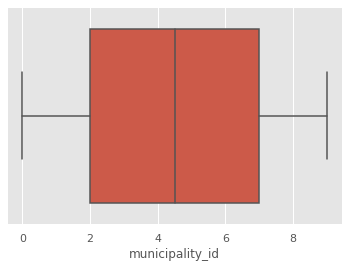

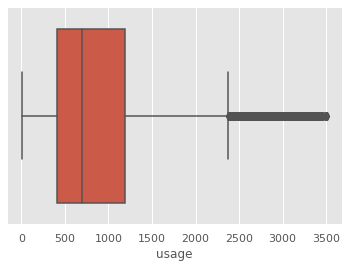

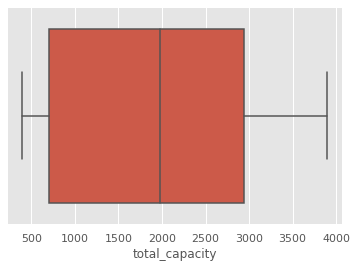

In [100]:
for i in num_column:
    sns.boxplot(x=df[i])
    plt.show()

In [101]:
#Remove Outlier
def detect_outliers_index(dataframe, column):
    Q1=dataframe[column].quantile(0.25)
    Q3=dataframe[column].quantile(0.75)
    IQR=Q3-Q1
    
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    
    ls=dataframe.index[(dataframe[column]<lower_bound)|(dataframe[column]>upper_bound)]
    return ls


In [102]:
def detect_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    return outliers

In [103]:
out_df=detect_outliers(num_column,num_column.columns)

In [104]:
out_df

,municipality_id,usage,total_capacity
33,4,2511,3893
43,4,2811,3893
57,4,3044,3893
60,4,3178,3893
70,4,3230,3893
...,...,...,...
13023,4,3176,3893
13036,4,3111,3893
13044,4,2980,3893
13050,4,2779,3893


In [105]:
print('Verisetinin outlier oranı --->>> %' + str((out_df.shape[0] / num_column.shape[0] *100)))
print('Örnek outlier:')
out_df.head(8)

Verisetinin outlier oranı --->>> %5.615914307574598
Örnek outlier:


,municipality_id,usage,total_capacity
33,4,2511,3893
43,4,2811,3893
57,4,3044,3893
60,4,3178,3893
70,4,3230,3893
87,4,3257,3893
96,4,3260,3893
108,4,3241,3893


# Setting the outlier values to min-max

In [106]:
def cap_outliers(series, iqr_threshold=1.5, verbose=False):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lbound = Q1 - iqr_threshold * IQR
    ubound = Q3 + iqr_threshold * IQR

    outliers = (series < lbound) | (series > ubound)

    series = series.copy()
    series.loc[series < lbound] = series.loc[~outliers].min()
    series.loc[series > ubound] = series.loc[~outliers].max()

    return series

In [107]:
df_setting_outlier=df.copy()

In [108]:
for feature in num_column:
    df_setting_outlier[feature] = cap_outliers(df[feature], verbose=True)

In [109]:
df_setting_outlier_num=df_setting_outlier.select_dtypes(exclude=['object','category','datetime'])

In [110]:
df_setting_outlier_OUT=detect_outliers(df_setting_outlier_num,df_setting_outlier_num.columns)

In [111]:
print('Verisetinin outlier oranı --->>> %' + str((df_setting_outlier_OUT.shape[0] / df_setting_outlier_num.shape[0] *100)))


Verisetinin outlier oranı --->>> %0.0


In [112]:
df=df_setting_outlier.copy()

In [113]:
df

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,0,204,2813
1,2017-06-04 07:59:42,1,129,397
2,2017-06-04 07:59:42,2,273,697
3,2017-06-04 07:59:42,3,623,1930
4,2017-06-04 07:59:42,4,1090,3893
...,...,...,...,...
13065,2017-08-19 16:30:35,5,202,587
13066,2017-08-19 16:30:35,6,1680,3113
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,8,1193,2947


# Create Model

In [114]:
df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)

In [115]:
df['timestamp'].min()

Timestamp('2017-06-04 07:59:42')

In [116]:
df['timestamp'].max()

Timestamp('2017-08-19 16:30:35')

In [117]:
test_data = pd.DataFrame()
train_data = pd.DataFrame()

In [118]:
train_data = df.query('timestamp < 20170804')          
test_data= df.query('20170805 <= timestamp <= 20170819')   

In [119]:
print("Train Set:", train_data.shape)
print("Test Set:", test_data.shape)

Train Set: (10390, 4)
Test Set: (2500, 4)


In [120]:
test_data

,timestamp,municipality_id,usage,total_capacity
10390,2017-08-05 08:02:03,0,209,2813
10391,2017-08-05 08:02:03,1,141,397
10392,2017-08-05 08:02:03,2,286,697
10393,2017-08-05 08:02:03,3,610,1930
10394,2017-08-05 08:02:03,4,1782,3893
...,...,...,...,...
12885,2017-08-18 16:30:25,5,215,587
12886,2017-08-18 16:30:25,6,1603,3113
12887,2017-08-18 16:30:25,7,1272,2019
12888,2017-08-18 16:30:25,8,928,2947


In [121]:
train_data

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,0,204,2813
1,2017-06-04 07:59:42,1,129,397
2,2017-06-04 07:59:42,2,273,697
3,2017-06-04 07:59:42,3,623,1930
4,2017-06-04 07:59:42,4,1090,3893
...,...,...,...,...
10385,2017-08-02 16:32:54,5,114,587
10386,2017-08-02 16:32:54,6,1018,3113
10387,2017-08-02 16:32:54,7,1169,2019
10388,2017-08-02 16:32:54,8,1035,2947


In [122]:
test_0 = test_data[(test_data['municipality_id']==0)]
train_0 = train_data[(train_data['municipality_id']==0)]

test_1 = test_data[(test_data['municipality_id']==1)]
train_1 = train_data[(train_data['municipality_id']==1)]

test_2 = test_data[(test_data['municipality_id']==2)]
train_2 = train_data[(train_data['municipality_id']==2)]

test_3 = test_data[(test_data['municipality_id']==3)]
train_3 = train_data[(train_data['municipality_id']==3)]

test_4 = test_data[(test_data['municipality_id']==4)]
train_4 = train_data[(train_data['municipality_id']==4)]

test_5 = test_data[(test_data['municipality_id']==5)]
train_5 = train_data[(train_data['municipality_id']==5)]

test_6 = test_data[(test_data['municipality_id']==6)]
train_6 = train_data[(train_data['municipality_id']==6)]

test_7 = test_data[(test_data['municipality_id']==7)]
train_7 = train_data[(train_data['municipality_id']==7)]

test_8 = test_data[(test_data['municipality_id']==8)]
train_8 =train_data[(train_data['municipality_id']==8)]

test_9 = test_data[(test_data['municipality_id']==9)]
train_9 = train_data[(train_data['municipality_id']==9)]

In [123]:
test_0.shape

(250, 4)

In [124]:
train_6.shape

(1039, 4)

In [153]:
def is_nun(num):
    return num != num

In [154]:
def fill_num(arr):
    for i in range(len(arr.values)):
        if is_nun(arr.values[i]):
            arr.values[i] = arr.mean()
    return arr

## Resample dataframe 

### Final Data

In [156]:
finaldata = train_data.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()

In [157]:
# FİNAL DATA 0
finaldata0 = train_0.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tsdata0 = train_0.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tsdata0 = fill_num(tsdata0)

In [158]:
# FİNAL DATA 1
finaldata1 = train_1.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tsdata1 = train_1.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tsdata1 = fill_num(tsdata1)

In [159]:
#FİNAL DATA 2
finaldata2 = train_2.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tsdata2 = train_2.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tsdata2 = fill_num(tsdata2)

In [160]:
#FİNAL DATA 3
finaldata3 = train_3.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tsdata3 = train_3.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tsdata3 = fill_num(tsdata3)

In [161]:
#FİNAL DATA 4
finaldata4 = train_4.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tsdata4 = train_4.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tsdata4 = fill_num(tsdata4)

In [162]:
#FİNAL DATA 5
finaldata5 = train_5.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tsdata5 = train_5.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tsdata5 = fill_num(tsdata5)

In [163]:
#FİNAL DATA 6
finaldata6 = train_6.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tsdata6 = train_6.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tsdata6 = fill_num(tsdata6)

In [164]:
#FİNAL DATA 7
finaldata7 = train_7.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tsdata7 = train_7.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tsdata7 = fill_num(tsdata7)

In [165]:
#FİNAL DATA 8
finaldata8 = train_8.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tsdata8 = train_8.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tsdata8 = fill_num(tsdata8)

In [166]:
#FİNAL DATA 9
finaldata9 = train_9.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tsdata9 = train_9.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tsdata9 = fill_num(tsdata9)

# Test Data

In [167]:
trydata = test_data.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()

In [168]:
#TRY DATA 0
trydata0 = test_0.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tstdata0 = test_0.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tstdata0 = fill_num(tstdata0)

In [169]:
#TRY DATA 1
trydata1 = test_1.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tstdata1 = test_1.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tstdata1 = fill_num(tstdata1)

In [170]:
#TRY DATA 2
trydata2 = test_2.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tstdata2 = test_2.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tstdata2 = fill_num(tstdata2)

In [171]:
#TRY DATA 3
trydata3 = test_3.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tstdata3 = test_3.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tstdata3 = fill_num(tstdata3)

In [172]:
#TRY DATA 4
trydata4 = test_4.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tstdata4 = test_4.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tstdata4 = fill_num(tstdata4)

In [173]:
#TRY DATA 5
trydata5 = test_5.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tstdata5 = test_5.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tstdata5 = fill_num(tstdata5)

In [174]:
#TRY DATA 6
trydata6 = test_6.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tstdata6 = test_6.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tstdata6 = fill_num(tstdata6)

In [175]:
#TRY DATA 7
trydata7 = test_7.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tstdata7 = test_7.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tstdata7 = fill_num(tstdata7)

In [176]:
#TRY DATA 8
trydata8 = test_8.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tstdata8 = test_8.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tstdata8 = fill_num(tstdata8)

In [177]:
#TRY DATA 9
trydata9 = test_9.groupby([pd.Grouper(key='timestamp', freq='H'), 'municipality_id'], as_index=False)['usage'].max()
tstdata9 = test_9.groupby([pd.Grouper(key='timestamp', freq='H')])['usage'].max()
tstdata9 = fill_num(tstdata9)

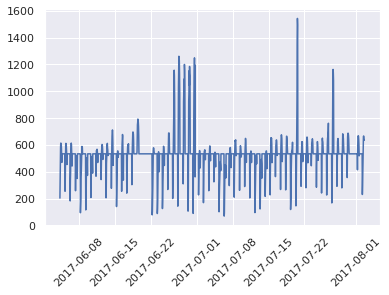

In [178]:
print()
sns.set()
plt.xticks(rotation=45)
plt.plot(tsdata0.index, tsdata0, )

In [190]:
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [191]:
def print_performance(y_test, y_pred):
    print('rmse:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('r2:', r2_score(y_test, y_pred))

#  BASE MODEL 

## Autoregressive Integrated Moving Average (ARIMA)


#### FOR MUNICIPALITY_ID = 0

In [192]:
from statsmodels.tsa.arima.model import ARIMA
Armamodel = ARIMA(tsdata0)
ARMAmodel = Armamodel.fit()

y_pred = ARMAmodel.get_forecast(len(tstdata0.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = tstdata0.index
y_pred_out = y_pred_df["Predictions"]

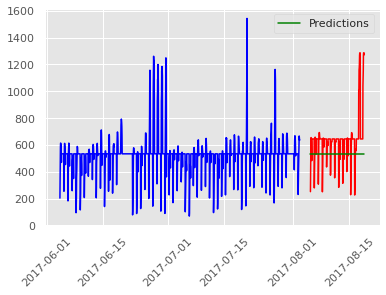

In [193]:
plt.plot(tsdata0, color = "blue")
plt.plot(tstdata0, color = "red")
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [194]:
print_performance(tstdata0,y_pred_df["Predictions"])

rmse: 199.65109826861132
r2: -0.44622130788137815


#### FOR MUNICIPALITY_ID = 1

In [195]:
Armamodel = ARIMA(tsdata1)
ARMAmodel = Armamodel.fit()

y_pred = ARMAmodel.get_forecast(len(tstdata1.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = tstdata1.index
y_pred_out = y_pred_df["Predictions"]

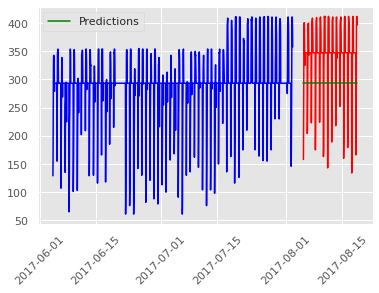

In [196]:
plt.plot(tsdata1, color = "blue")
plt.plot(tstdata1, color = "red")
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [197]:
print_performance(tstdata1,y_pred_df["Predictions"])

rmse: 75.68174392093204
r2: -1.0316620067467723


#### FOR MUNICIPALITY_ID = 2

In [198]:
Armamodel = ARIMA(tsdata2)
ARMAmodel = Armamodel.fit()

y_pred = ARMAmodel.get_forecast(len(tstdata2.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = tstdata2.index
y_pred_out = y_pred_df["Predictions"]

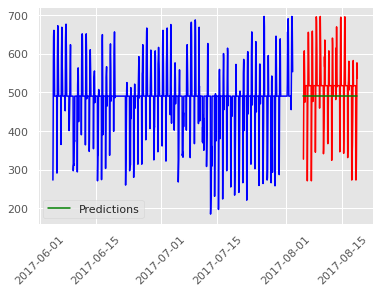

In [199]:
plt.plot(tsdata2, color = "blue")
plt.plot(tstdata2, color = "red")
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [200]:
print_performance(tstdata2,y_pred_df["Predictions"])

rmse: 81.20502383059869
r2: -0.1239802518752342


#### FOR MUNICIPALITY_ID = 3

In [201]:
Armamodel = ARIMA(tsdata3)
ARMAmodel = Armamodel.fit()

y_pred = ARMAmodel.get_forecast(len(tstdata3.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = tstdata4.index
y_pred_out = y_pred_df["Predictions"]

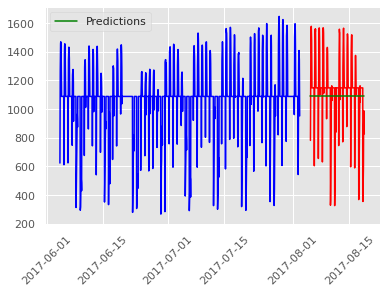

In [202]:
plt.plot(tsdata3, color = "blue")
plt.plot(tstdata3, color = "red")
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [203]:
print_performance(tstdata3,y_pred_df["Predictions"])

rmse: 236.9468366661027
r2: -0.06787845425628403


#### FOR MUNICIPALITY_ID = 4

In [204]:
Armamodel = ARIMA(tsdata4)
ARMAmodel = Armamodel.fit()

y_pred = ARMAmodel.get_forecast(len(tstdata4.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = tstdata4.index
y_pred_out = y_pred_df["Predictions"]

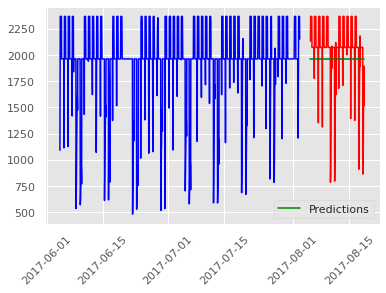

In [205]:
plt.plot(tsdata4, color = "blue")
plt.plot(tstdata4, color = "red")
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [206]:
print_performance(tstdata4,y_pred_df["Predictions"])

rmse: 312.4947335862762
r2: -0.14086881227451897


#### FOR MUNICIPALITY_ID = 5

In [207]:
Armamodel = ARIMA(tsdata5)
ARMAmodel = Armamodel.fit()

y_pred = ARMAmodel.get_forecast(len(tstdata5.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = tstdata1.index
y_pred_out = y_pred_df["Predictions"]

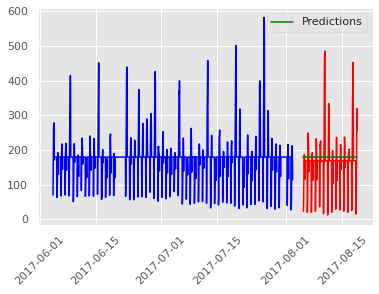

In [209]:
plt.plot(tsdata5, color = "blue")
plt.plot(tstdata5, color = "red")
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [210]:
print_performance(tstdata5,y_pred_df["Predictions"])


rmse: 70.24114638837017
r2: -0.024615646656225953


#### FOR MUNICIPALITY_ID = 6

In [211]:
Armamodel = ARIMA(tsdata6)
ARMAmodel = Armamodel.fit()

y_pred = ARMAmodel.get_forecast(len(tstdata6.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = tstdata6.index
y_pred_out = y_pred_df["Predictions"]

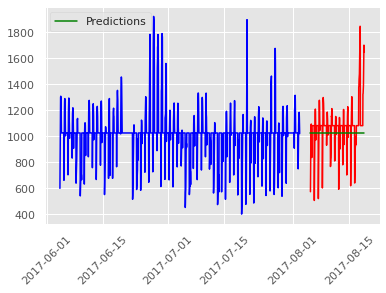

In [212]:
plt.plot(tsdata6, color = "blue")
plt.plot(tstdata6, color = "red")
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [213]:
print_performance(tstdata6,y_pred_df["Predictions"])

rmse: 180.20376106121515
r2: -0.10841037570303103


#### FOR MUNICIPALITY_ID = 7

In [214]:
Armamodel = ARIMA(tsdata7)
ARMAmodel = Armamodel.fit()

y_pred = ARMAmodel.get_forecast(len(tstdata7.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = tstdata7.index
y_pred_out = y_pred_df["Predictions"]

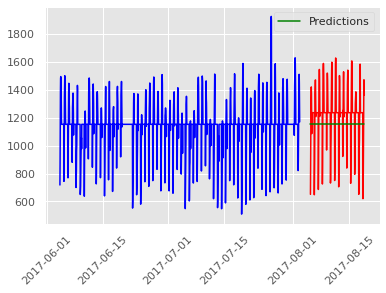

In [215]:
plt.plot(tsdata7, color = "blue")
plt.plot(tstdata7, color = "red")
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [216]:
print_performance(tstdata7,y_pred_df["Predictions"])

rmse: 199.60084623348072
r2: -0.20962643456497987


In [217]:
Armamodel = ARIMA(tsdata8)
ARMAmodel = Armamodel.fit()

y_pred = ARMAmodel.get_forecast(len(tstdata8.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = tstdata8.index
y_pred_out = y_pred_df["Predictions"]

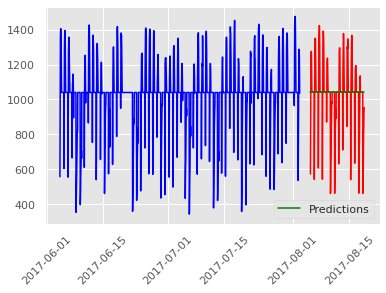

In [220]:
plt.plot(tsdata8, color = "blue")
plt.plot(tstdata8, color = "red")
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [221]:
print_performance(tstdata8,y_pred_df["Predictions"])

rmse: 177.99889100091565
r2: -0.0001850350376400023


#### FOR MUNICIPALITY_ID = 9

In [222]:
Armamodel = ARIMA(tsdata9)
ARMAmodel = Armamodel.fit()

y_pred = ARMAmodel.get_forecast(len(tstdata9.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = tstdata9.index
y_pred_out = y_pred_df["Predictions"]

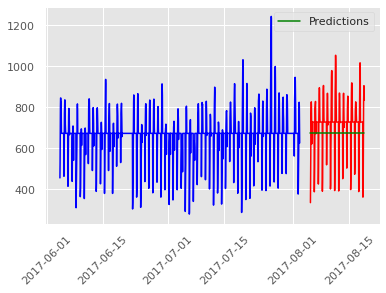

In [223]:
plt.plot(tsdata9, color = "blue")
plt.plot(tstdata9, color = "red")
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend()

In [224]:
print_performance(tstdata9,y_pred_df["Predictions"])

rmse: 126.70232811315569
r2: -0.2363981864845197
